In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [13]:
# === Load and Clean the CSV File ===
file_path = "real_time_S&P_500.csv"

# Load CSV while skipping the first row (Ticker row)
df = pd.read_csv(file_path, skiprows=1)  # Skip the first row to fix headers

# Rename first column to 'Date'
df.rename(columns={df.columns[0]: "Date"}, inplace=True)

# Convert 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

# Drop rows where 'Date' could not be parsed
df.dropna(subset=["Date"], inplace=True)

# Set 'Date' as the index
df.set_index("Date", inplace=True)

# Identify the correct 'Close' column
print("Columns in dataset:", df.columns)  # Check column names to identify 'Close' column

close_col = df.columns[1]  # Assuming 'Close' is the second column (adjust if needed)
df.rename(columns={close_col: "Close"}, inplace=True)

# === Recompute Log Returns ===
df["Log_Returns"] = np.log(df["Close"] / df["Close"].shift(1))
df.dropna(inplace=True)  # Drop NaNs from the first row

# Save the cleaned data
df.to_csv("processed_sp500.csv")

Columns in dataset: Index(['SPY', 'SPY.1', 'SPY.2', 'SPY.3', 'SPY.4', 'Unnamed: 6'], dtype='object')


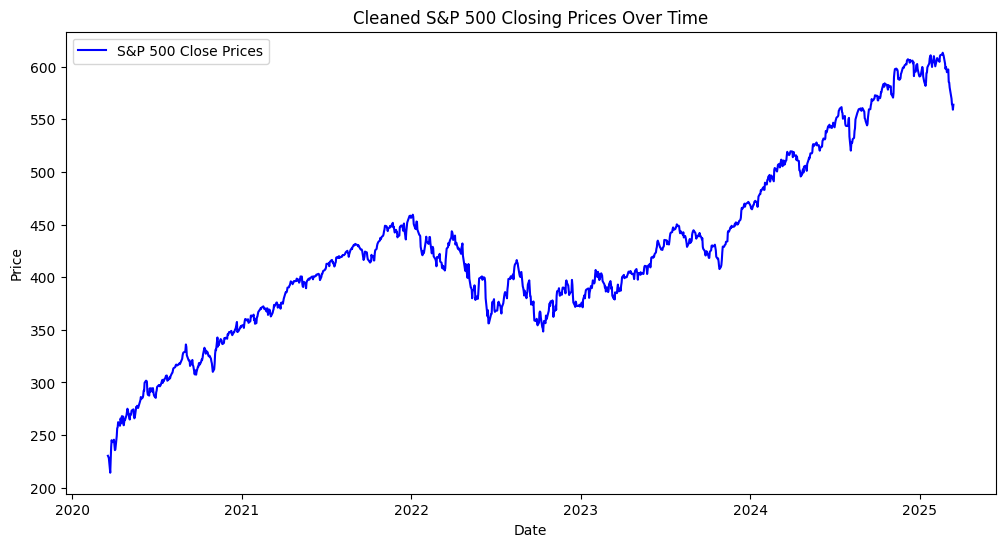

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="S&P 500 Close Prices", color="blue")
plt.title("Cleaned S&P 500 Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [15]:
df = pd.read_csv("processed_sp500.csv", index_col=0, parse_dates=True)

# === Feature Scaling Using StandardScaler ===
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler(feature_range=(-1, 1))  # Normalize between -1 and 1
df["Scaled_Volatility"] = scaler.fit_transform(df[["Log_Returns"]])

# === Create Sequences for Training ===
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 180  # More history for better predictions
X, y = create_sequences(df["Scaled_Volatility"].values, sequence_length)

# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape for Transformer input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("✅ Data Processing Complete! Model Ready for Training.")

✅ Data Processing Complete! Model Ready for Training.


In [16]:
# === Define Transformer Model Architecture ===
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(seq_length, embed_dim=128, num_heads=8, ff_dim=256):
    inputs = Input(shape=(seq_length, 1))
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = Dense(100, activation="relu")(x)  # Larger hidden layer
    x = Dropout(0.3)(x)  # More dropout for regularization
    x = Dense(50, activation="relu")(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")  # Switching to MSE
    return model

# Build Transformer Model
transformer_model = build_transformer_model(sequence_length)


In [17]:
# === Train the Model with Early Stopping ===
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

transformer_model.fit(
    X_train, y_train, 
    epochs=200, batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1, callbacks=[early_stopping]
)


Epoch 1/200
27/27 [==============================] - 26s 933ms/step - loss: 0.0212 - val_loss: 0.0127
Epoch 2/200
27/27 [==============================] - 26s 959ms/step - loss: 0.0210 - val_loss: 0.0126
Epoch 3/200
27/27 [==============================] - 25s 947ms/step - loss: 0.0210 - val_loss: 0.0126
Epoch 4/200
27/27 [==============================] - 24s 909ms/step - loss: 0.0209 - val_loss: 0.0126
Epoch 5/200
27/27 [==============================] - 25s 914ms/step - loss: 0.0210 - val_loss: 0.0126
Epoch 6/200
27/27 [==============================] - 24s 907ms/step - loss: 0.0209 - val_loss: 0.0126
Epoch 7/200
27/27 [==============================] - 25s 939ms/step - loss: 0.0210 - val_loss: 0.0126
Epoch 8/200
27/27 [==============================] - 25s 936ms/step - loss: 0.0210 - val_loss: 0.0126
Epoch 9/200
27/27 [==============================] - 3363s 129s/step - loss: 0.0210 - val_loss: 0.0126
Epoch 10/200
27/27 [==============================] - 24s 905ms/step - loss: 0.02

In [ ]:
# === Make Predictions ===
predicted_volatility = transformer_model.predict(X_test)


In [ ]:
# Reverse scale the predictions
predicted_volatility = scaler.inverse_transform(predicted_volatility.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [ ]:
# === Compute Model Performance Metrics ===
mae = mean_absolute_error(y_test_actual, predicted_volatility)
mse = mean_squared_error(y_test_actual, predicted_volatility)
rmse = np.sqrt(mse)

print(f"Transformer Model MAE: {mae:.6f}")
print(f"Transformer Model RMSE: {rmse:.6f}")


In [ ]:
# === Save Predictions to CSV ===
df_pred = pd.DataFrame({
    "Date": df.index[-len(y_test):],  # Use same index as test set
    "Actual Volatility": y_test_actual.flatten(),
    "Predicted Volatility (Transformer)": predicted_volatility.flatten()
})
df_pred.to_csv("transformer_volatility_predictions.csv", index=False)


In [ ]:
# === Plot Actual vs. Predicted Volatility ===
plt.figure(figsize=(12, 6))
plt.plot(df_pred["Date"], df_pred["Actual Volatility"], label="Actual Volatility", color="red")
plt.plot(df_pred["Date"], df_pred["Predicted Volatility (Transformer)"], label="Predicted Volatility (Transformer)", color="blue", linestyle="dashed")
plt.title("Transformer Model Forecast vs. Actual Volatility")
plt.legend()
plt.show()

print("✅ Process Complete! Predictions saved in 'transformer_volatility_predictions.csv'")